In [1]:
#set up environment
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization

# create directories for the notebook. DO NOT change
data_dir = 'data/processed/06_Kraken_results'
!data_dir = 'data/processed/06_Kraken_results'

/usr/bin/sh: line 1: data_dir: command not found


# Taxonomy: Kraken2 based classification
For classification we decided to use the kraken2 Moshpit tool and used the combined dereplicated mags with pluspfp16 Kraken2 db. If you are not familiar with Kraken "[pluspfp](https://doi.org/10.1186/s13059-019-1891-0)" contains Reference Sequences of the standard: archaea, bacteria, viral, plasmid, human1, UniVec_Core; in addition it also contains protozoa, fungi and plants. The rationale behind this choice is the attempt to classify the dereplicated mags that were extracted in step 03 from all 3 domains of life. A size-capped database was used due to limits in computational usage (16Gb).
### Step 1: downloading db

the following script was supposed to download and classify only bacteria dereplicates directly. It has not been modified since a an alternative was used for the actual classification (see next markdown) and the used database is the same.

```
#!/bin/bash
#SBATCH --job-name=Kraken2_Taxonomy
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=20
#SBATCH --mem-per-cpu=4GB
#SBATCH --time=48:00:00
#SBATCH --output=/cluster/home/%u/applied_bioinformatics/01_logs/%x_%j_out.log
#SBATCH --error=/cluster/home/%u/applied_bioinformatics/01_logs/%x_%j_err.log

module load eth_proxy

# initialize conda manually
source /cluster/home/$USER/miniconda3/etc/profile.d/conda.sh
conda activate qiime2-moshpit-2025.7

#variables
CACHE_DIR=/cluster/scratch/$USER/cache
mkdir /cluster/scratch/$USER/03_artifacts/Kraken_DB
KRAKEN_DB=/cluster/scratch/$USER/03_artifacts/Kraken_DB
MAGS_DIR=/cluster/scratch/$USER/03_artifacts/dereplicates/dereplicates/mags_filtered_bacteria_dereplicates.qza

mkdir $KRAKEN_DB 
mkdir $KRAKEN_DB/Classify
mkdir $KRAKEN_DB/Taxonomy

 mosh annotate build-kraken-db \
    --p-collection pluspfp16 \
    --p-threads 48 \
    --p-kmer-len 35 \
    --o-kraken2-db /cluster/scratch/$USER/cache:Kraken2_pluspfp16 \
    --o-bracken-db /cluster/scratch/$USER/cache:Bracken2_pluspfp16 \
    --use-cache /cluster/scratch/$USER/cache \
    --verbose
```

### Step 2: Classification
Premise: a bug in how moshpit handles cpus for this step did not allow to use a .slurms.sh. A pipeline of commands was fed to the interactive node instead.

As Previously mentioned the input is the combined of the 3 dereplicated mags obtained in Notebook 03. This command results in 2 files: the reports and the hits per dereplicated set. 

```
#!/bin/bash
srun --pty -n 20 --mem-per-cpu=4G -t 08:00:00 bash #allocate resources to the interactive node 

conda activate qiime2-moshpit-2025.7 # activate conda
mosh annotate classify-kraken2 \
    --i-seqs /cluster/scratch/$USER/03_artifacts/dereplicated_mags/dereplicates/mags_filtered_bacteria_dereplicates.qza \
    --i-db /cluster/scratch/$USER/cache:Kraken2_pluspfp16 \
    --p-threads 60 \
    --p-confidence 0.5 \
    --o-reports /cluster/scratch/$USER/03_artifacts/Kraken_DB/Classify/kraken_reports_mags_derep_50.qza \
    --o-outputs /cluster/scratch/$USER/03_artifacts/Kraken_DB/Classify/kraken_hits_derep_50.qza \
    --use-cache /cluster/scratch/$USER/cache \
    --verbose
```

An additional problem was encountered where the previous cannot be used anymore to generate taxonomy for eukaryotes, archaea or even replicate the bacterial resuslts that are used for this notebook. The command runs without error, but for every classification 0 classified sequences are returned. After trying different combination databases, dereplicated MAGs imput, even importing the Kraken2_db manually into the cache (like during the first and only successfull run) no solution has been found.
The results are thus limited to an irriproducible draft of a dereplicate set of which the feature table no longer exists, due to Euler scratch cleaning. the inputs and code have also been submitted to our supervisor, who succeded in running the code. Due to time constraints no result could be produced with it. The limits imposed by this technical problem are significant, but considering the amount of time and effort that have been sunk into trying to solve this problem, it can be affirmed with a degree of certainty that it was not due to a lack of commitment. 

```
...
Running external command line application(s). This may print messages to stdout and/or stderr.
The command(s) being run are below. These commands cannot be manually re-run as they will depend on temporary files that no longer exist.

Command: kraken2 --threads 60 --confidence 0.5 --minimum-base-quality 0 --minimum-hit-groups 2 --db /cluster/scratch/emotta/cache/data/d3a3379b-0638-40f1-8f16-f4db81b4fca4/data --report /cluster/scratch/emotta/cache/processes/3220858-1766133079.49@emotta/tmp/q2-OutPath-jiie1xos/b016ed44-d4d7-4927-b6fc-b8eb341adbf7.report.txt --output /cluster/scratch/emotta/cache/processes/3220858-1766133079.49@emotta/tmp/q2-OutPath-a3j971ce/b016ed44-d4d7-4927-b6fc-b8eb341adbf7.output.txt /cluster/scratch/emotta/cache/data/04a3673e-9373-490e-885b-fe8d073935f1/data/b016ed44-d4d7-4927-b6fc-b8eb341adbf7.fasta

Loading database information... done.
449 sequences (10.24 Mbp) processed in 0.453s (59.5 Kseq/m, 1357.18 Mbp/m).
  0 sequences classified (0.00%)
  449 sequences unclassified (100.00%)
...
```

### Step 3: annotation
Annotation is necessary to combine the reports and the hits into a feature-table for the Taxonomy.
The end result is a visualization of the table of taxonomical classification of all dereplicated samples.

In [2]:
#annotate hits to tree
! qiime annotate kraken2-to-mag-features \
    --i-reports $data_dir/Classify/kraken_reports_mags_derep_50.qza \
    --i-outputs $data_dir/Classify/kraken_hits_derep_50.qza \
    --o-taxonomy $data_dir/mags-taxonomy.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureData[Taxonomy] to: data/processed/06_Kraken_results/mags-taxonomy.qza


In [3]:
#create taxonomy viusalization
! qiime metadata tabulate \
    --m-input-file $data_dir/mags-taxonomy.qza \
    --o-visualization $data_dir/taxonomy.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/processed/06_Kraken_results/taxonomy.qzv


In [4]:
Visualization.load(f"{data_dir}/taxonomy.qzv")

<visualization: Visualization uuid: 3bf582e3-f06c-466b-a0ff-d636ec837031>

### Step 4: Downstream analysis
To plot the taxonomy the R **metacoder** library was used. The result is a heat tree of the whole classification for bacteria to a class level.

In [5]:
!qiime tools export \
    --input-path $data_dir/taxonomy.qzv \
    --output-path $data_dir/taxonomy_out

Exported data/processed/06_Kraken_results/taxonomy.qzv as Visualization to directory data/processed/06_Kraken_results/taxonomy_out


In [6]:
taxonomy = pd.read_csv('data/06_Kraken_results/taxonomy_out/metadata.tsv', sep = '\t')

In [7]:
#setup R environment for metacoder plot

!pip install rpy2
%load_ext rpy2.ipython
import rpy2

In [8]:
%%R
install.packages("remotes")
remotes::install_github("grunwaldlab/metacoder")
library(metacoder)
library(readr)



--- Please select a CRAN mirror for use in this session ---
Secure CRAN mirrors 

 1: 0-Cloud [https]                   2: Australia (Canberra) [https]   
 3: Australia (Melbourne 1) [https]   4: Australia (Melbourne 2) [https]
 5: Austria (Wien) [https]            6: Belgium (Brussels) [https]     
 7: Brazil (PR) [https]               8: Brazil (SP 1) [https]          
 9: Brazil (SP 2) [https]            10: Bulgaria [https]               
11: Canada (MB) [https]              12: Canada (ON 1) [https]          
13: Canada (ON 2) [https]            14: Chile (Santiago) [https]       
15: China (Beijing 1) [https]        16: China (Beijing 2) [https]      
17: China (Beijing 3) [https]        18: China (Hefei) [https]          
19: China (Hong Kong) [https]        20: China (Lanzhou) [https]        
21: China (Nanjing) [https]          22: China (Shanghai 2) [https]     
23: China (Shenzhen) [https]         24: China (Wuhan) [https]          
25: Colombia (Cali) [https]          26: C

Selection:  60


R[write to console]: trying URL 'https://stat.ethz.ch/CRAN/src/contrib/remotes_2.5.0.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 164496 bytes (160 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to consol

These packages have more recent versions available.
It is recommended to update all of them.
Which would you like to update?

 1: All                                         
 2: CRAN packages only                          
 3: None                                        
 4: isoband      (0.2.7     -> 0.3.0    ) [CRAN]
 5: stringi      (1.8.4     -> 1.8.7    ) [CRAN]
 6: magrittr     (2.0.3     -> 2.0.4    ) [CRAN]
 7: xfun         (0.52      -> 0.55     ) [CRAN]
 8: xml2         (1.3.6     -> 1.5.1    ) [CRAN]
 9: stringr      (1.5.1     -> 1.6.0    ) [CRAN]
10: curl         (6.2.2     -> 7.0.0    ) [CRAN]
11: pillar       (1.11.0    -> 1.11.1   ) [CRAN]
12: hms          (1.1.3     -> 1.1.4    ) [CRAN]
13: RcppArmad... (14.4.2-1  -> 15.2.3-1 ) [CRAN]
14: pixmap       (0.4-13    -> 0.4-14   ) [CRAN]
15: igraph       (2.0.3     -> 2.2.1    ) [CRAN]
16: digest       (0.6.37    -> 0.6.39   ) [CRAN]
17: tinytex      (0.57      -> 0.58     ) [CRAN]
18: yaml         (2.3.10    -> 2.3.12   )

Enter one or more numbers, or an empty line to skip updates:  2


S7           (NA        -> 0.2.1    ) [CRAN]
isoband      (0.2.7     -> 0.3.0    ) [CRAN]
commonmark   (NA        -> 2.0.0    ) [CRAN]
stringi      (1.8.4     -> 1.8.7    ) [CRAN]
magrittr     (2.0.3     -> 2.0.4    ) [CRAN]
litedown     (NA        -> 0.9      ) [CRAN]
xfun         (0.52      -> 0.55     ) [CRAN]
xml2         (1.3.6     -> 1.5.1    ) [CRAN]
stringr      (1.5.1     -> 1.6.0    ) [CRAN]
markdown     (NA        -> 2.0      ) [CRAN]
curl         (6.2.2     -> 7.0.0    ) [CRAN]
pillar       (1.11.0    -> 1.11.1   ) [CRAN]
hms          (1.1.3     -> 1.1.4    ) [CRAN]
RcppArmad... (14.4.2-1  -> 15.2.3-1 ) [CRAN]
pixmap       (0.4-13    -> 0.4-14   ) [CRAN]
quadprog     (NA        -> 1.5-8    ) [CRAN]
igraph       (2.0.3     -> 2.2.1    ) [CRAN]
fastmatch    (NA        -> 1.1-6    ) [CRAN]
digest       (0.6.37    -> 0.6.39   ) [CRAN]
tinytex      (0.57      -> 0.58     ) [CRAN]
yaml         (2.3.10    -> 2.3.12   ) [CRAN]
evaluate     (1.0.4     -> 1.0.5    ) [CRAN]
checkmate 

R[write to console]: Installing 65 packages: S7, isoband, commonmark, stringi, magrittr, litedown, xfun, xml2, stringr, markdown, curl, pillar, hms, RcppArmadillo, pixmap, quadprog, igraph, fastmatch, digest, tinytex, yaml, evaluate, checkmate, rex, purrr, ratelimitr, triebeard, vroom, openssl, rmarkdown, colorspace, htmltools, ggplot2, readr, pbapply, Hmisc, WikidataQueryServiceR, WikipediR, httpcode, urltools, crul, data.table, WikidataR, solrium, XML, rncl, rentrez, gridtext, shades, segmented, phangorn, wikitaxa, natserv, worrms, ritis, rotl, rredlist, zoo, GA, cowplot, vegan, ggfittext, RCurl, seqinr, taxize

R[write to console]: trying URL 'https://stat.ethz.ch/CRAN/src/contrib/S7_0.2.1.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 184141 bytes (179 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: 

x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c init.c -o init.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3

installing to /opt/conda/lib/R/library/00LOCK-S7/00new/S7/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (S7)
* installing *source* package ‘isoband’ ...
** package ‘isoband’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C++ compiler: ‘x86_64-conda-linux-gnu-c++ (conda-forge gcc 15.1.0-5) 15.1.0’


x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/opt/conda/lib/R/include" -DNDEBUG  -I'/opt/conda/lib/R/library/cpp11/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c clip-lines.cpp -o clip-lines.o
x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/opt/conda/lib/R/include" -DNDEBUG  -I'/opt/conda/lib/R/library/cpp11/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fP

installing to /opt/conda/lib/R/library/00LOCK-isoband/00new/isoband/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (isoband)
* installing *source* package ‘commonmark’ ...
** package ‘commonmark’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘x86_64-conda-linux-gnu-cc (conda-forge gcc 15.1.0-5) 15.1.0’


x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -Icmark -I. -DCMARK_GFM_STATIC_DEFINE -DCMARK_GFM_EXTENSIONS_STATIC_DEFINE -DR_NO_REMAP -DSTRICT_R_HEADERS  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -fvisibility=hidden -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c extensions.c -o extensions.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -Icmark -I. -DCMARK_GFM_STATIC_DEFINE -DCMARK_GFM_EXTENSIONS_STATIC_DEFINE -DR_NO_REMAP -DSTRICT_R_HEADERS  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -fvisibility=hidden -fpic  -march=no

installing to /opt/conda/lib/R/library/00LOCK-commonmark/00new/commonmark/libs
** R
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (commonmark)
* installing *source* package ‘stringi’ ...
** package ‘stringi’ successfully unpacked and MD5 sums checked
** using staged installation


checking for R_HOME... /opt/conda/lib/R
checking for R... /opt/conda/lib/R/bin/R
checking for endianness... little
checking for cat... /usr/bin/cat
checking whether the C++ compiler works... yes
checking for C++ compiler default output file name... a.out
checking for suffix of executables... 
checking whether we are cross compiling... no
checking for suffix of object files... o
checking whether the compiler supports GNU C++... yes
checking whether x86_64-conda-linux-gnu-c++ -std=gnu++17 accepts -g... yes
checking for x86_64-conda-linux-gnu-c++ -std=gnu++17 option to enable C++11 features... none needed
checking whether the C++ compiler supports the 'long long' type... yes
checking whether the compiler implements namespaces... yes
checking whether the compiler supports the Standard Template Library... yes
checking whether std::map is available... yes
checking for pkg-config... no
*** 'pkg-config' not found
*** Trying with 'standard' fallback flags
checking whether an ICU4C-based project

** libs
using C++ compiler: ‘x86_64-conda-linux-gnu-c++ (conda-forge gcc 15.1.0-5) 15.1.0’


x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/opt/conda/lib/R/include" -DNDEBUG -I.   -UDEBUG -DNDEBUG -DU_HAVE_ELF_H   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -fpic -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c stri_callables.cpp -o stri_callables.o
x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/opt/conda/lib/R/include" -DNDEBUG -I.   -UDEBUG -DNDEBUG -DU_HAVE_ELF_H   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -fpic -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vec

In file included from stri_ICU_settings.cpp:37:
uconfig_local.h:42:9: warning: 'UCONFIG_USE_WINDOWS_LCID_MAPPING_API' redefined
   42 | #define UCONFIG_USE_WINDOWS_LCID_MAPPING_API 0
      |         ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
In file included from /opt/conda/include/unicode/platform.h:24,
                 from /opt/conda/include/unicode/ptypes.h:52,
                 from stri_external.h:52,
                 from stri_stringi.h:36,
                 from stri_ICU_settings.cpp:33:
/opt/conda/include/unicode/uconfig.h:391:12: note: this is the location of the previous definition
  391 | #   define UCONFIG_USE_WINDOWS_LCID_MAPPING_API 1
      |            ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/opt/conda/lib/R/include" -DNDEBUG -I.   -UDEBUG -DNDEBUG -DU_HAVE_ELF_H   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -fpic -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c stri_join.cpp -o stri_join.o
x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/opt/conda/lib/R/include" -DNDEBUG -I.   -UDEBUG -DNDEBUG -DU_HAVE_ELF_H   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -fpic -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fP

In file included from stri_stringi.cpp:40:
uconfig_local.h:42:9: warning: 'UCONFIG_USE_WINDOWS_LCID_MAPPING_API' redefined
   42 | #define UCONFIG_USE_WINDOWS_LCID_MAPPING_API 0
      |         ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
In file included from /opt/conda/include/unicode/platform.h:24,
                 from /opt/conda/include/unicode/ptypes.h:52,
                 from stri_external.h:52,
                 from stri_stringi.h:36,
                 from stri_stringi.cpp:33:
/opt/conda/include/unicode/uconfig.h:391:12: note: this is the location of the previous definition
  391 | #   define UCONFIG_USE_WINDOWS_LCID_MAPPING_API 1
      |            ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/opt/conda/lib/R/include" -DNDEBUG -I.   -UDEBUG -DNDEBUG -DU_HAVE_ELF_H   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -fpic -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c stri_sub.cpp -o stri_sub.o
x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/opt/conda/lib/R/include" -DNDEBUG -I.   -UDEBUG -DNDEBUG -DU_HAVE_ELF_H   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -fpic -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC

installing via 'install.libs.R' to /opt/conda/lib/R/library/00LOCK-stringi/00new/stringi
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (stringi)
* installing *source* package ‘magrittr’ ...
** package ‘magrittr’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘x86_64-conda-linux-gnu-cc (conda-forge gcc 15.1.0-5) 15.1.0’


x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c pipe.c -o pipe.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3

installing to /opt/conda/lib/R/library/00LOCK-magrittr/00new/magrittr/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (magrittr)
* installing *source* package ‘xfun’ ...
** package ‘xfun’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘x86_64-conda-linux-gnu-cc (conda-forge gcc 15.1.0-5) 15.1.0’


x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c base64.c -o base64.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4

installing to /opt/conda/lib/R/library/00LOCK-xfun/00new/xfun/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (xfun)
* installing *source* package ‘xml2’ ...
** package ‘xml2’ successfully unpacked and MD5 sums checked
** using staged installation


Found pkg-config cflags and libs!
Using PKG_CFLAGS=-I/opt/conda/include/libxml2 -I/opt/conda/include
Using PKG_LIBS=-L/opt/conda/lib -lxml2 -L/opt/conda/lib -lz -L/opt/conda/lib -llzma -L/opt/conda/lib -licui18n -licuuc -licudata -L/opt/conda/lib -lm -ldl
x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/opt/conda/lib/R/include" -DNDEBUG -I../inst/include -I/opt/conda/include/libxml2 -I/opt/conda/include -DUCHAR_TYPE=wchar_t -DU_SHOW_CPLUSPLUS_API=0 -DSTRICT_R_HEADERS -DR_NO_REMAP  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -fvisibility=hidden -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix

** libs
using C compiler: ‘x86_64-conda-linux-gnu-cc (conda-forge gcc 15.1.0-5) 15.1.0’
using C++ compiler: ‘x86_64-conda-linux-gnu-c++ (conda-forge gcc 15.1.0-5) 15.1.0’


x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -I../inst/include -I/opt/conda/include/libxml2 -I/opt/conda/include -DUCHAR_TYPE=wchar_t -DU_SHOW_CPLUSPLUS_API=0 -DSTRICT_R_HEADERS -DR_NO_REMAP  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -fvisibility=hidden -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c init.c -o init.o
x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/opt/conda/lib/R/include" -DNDEBUG -I../inst/include -I/opt/conda/include/libxml2 -I/opt/conda/include -DUCHAR_TYPE=wchar_t -DU_SHOW_CPLUSPLUS_API=0 -DSTRICT_R_HEADERS -DR_NO_REMAP  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/con

installing to /opt/conda/lib/R/library/00LOCK-xml2/00new/xml2/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (xml2)
* installing *source* package ‘curl’ ...
** package ‘curl’ successfully unpacked and MD5 sums checked
** using staged installation


Using PKG_CFLAGS=
Using PKG_LIBS=-lcurl
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -DSTRICT_R_HEADERS -DR_NO_REMAP  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -fvisibility=hidden -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c callbacks.c -o callbacks.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -DSTRICT_R_HEADERS -DR_NO_REMAP  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -fvisibility=hidden -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isys

** libs
using C compiler: ‘x86_64-conda-linux-gnu-cc (conda-forge gcc 15.1.0-5) 15.1.0’


x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -DSTRICT_R_HEADERS -DR_NO_REMAP  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -fvisibility=hidden -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c download.c -o download.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -DSTRICT_R_HEADERS -DR_NO_REMAP  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -fvisibility=hidden -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=

installing to /opt/conda/lib/R/library/00LOCK-curl/00new/curl/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (curl)
* installing *source* package ‘pillar’ ...
** package ‘pillar’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a

checking whether the C++ compiler works... yes
checking for C++ compiler default output file name... a.out
checking for suffix of executables... 
checking whether we are cross compiling... no
checking for suffix of object files... o
checking whether the compiler supports GNU C++... yes
checking whether x86_64-conda-linux-gnu-c++ -std=gnu++17 accepts -g... yes
checking for x86_64-conda-linux-gnu-c++ -std=gnu++17 option to enable C++11 features... none needed
checking how to run the C++ preprocessor... x86_64-conda-linux-gnu-c++ -std=gnu++17 -E
checking whether the compiler supports GNU C++... (cached) yes
checking whether x86_64-conda-linux-gnu-c++ -std=gnu++17 accepts -g... (cached) yes
checking for x86_64-conda-linux-gnu-c++ -std=gnu++17 option to enable C++11 features... (cached) none needed
checking what system we are on... running Linux on x86_64
checking whether we have a suitable tempdir... /tmp
checking whether on Linux... yes
checking whether R CMD SHLIB can already compile Ope

** libs
using C++ compiler: ‘x86_64-conda-linux-gnu-c++ (conda-forge gcc 15.1.0-5) 15.1.0’


x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/opt/conda/lib/R/include" -DNDEBUG -I../inst/include -DARMA_USE_CURRENT -I'/opt/conda/lib/R/library/Rcpp/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -fopenmp -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c RcppExports.cpp -o RcppExports.o
x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/opt/conda/lib/R/include" -DNDEBUG -I../inst/include -DARMA_USE_CURRENT -I'/opt/conda/lib/R/library/Rcpp/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -fopenmp -fpic  -fvisibil

installing to /opt/conda/lib/R/library/00LOCK-RcppArmadillo/00new/RcppArmadillo/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (RcppArmadillo)
* installing *source* package ‘pixmap’ ...
** package ‘pixmap’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of tempor

x86_64-conda-linux-gnu-gfortran  -fvisibility=hidden -fpic -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix -msse2 -mfpmath=sse   -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c aind.f -o aind.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vector

installing to /opt/conda/lib/R/library/00LOCK-quadprog/00new/quadprog/libs
** R
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (quadprog)
* installing *source* package ‘fastmatch’ ...
** package ‘fastmatch’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘x86_64-conda-linux-gnu-cc (conda-forge gcc 15.1.0-5) 15.1.0’


x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c ctapply.c -o ctapply.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base

installing to /opt/conda/lib/R/library/00LOCK-fastmatch/00new/fastmatch/libs
** R
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (fastmatch)
* installing *source* package ‘digest’ ...
** package ‘digest’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘x86_64-conda-linux-gnu-cc (conda-forge gcc 15.1.0-5) 15.1.0’
using C++ compiler: ‘x86_64-conda-linux-gnu-c++ (conda-forge gcc 15.1.0-5) 15.1.0’


x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/opt/conda/lib/R/include" -DNDEBUG -I.  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c SpookyV2.cpp -o SpookyV2.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -I.  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/bui

installing to /opt/conda/lib/R/library/00LOCK-digest/00new/digest/libs
** R
** demo
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (digest)
* installing *source* package ‘yaml’ ...
** package ‘yaml’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘x86_64-conda-linux-gnu-cc (conda-forge gcc 15.1.0-5) 15.1.0’


x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -I. -DNDEBUG  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c api.c -o api.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -I. -DNDEBUG  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/

installing to /opt/conda/lib/R/library/00LOCK-yaml/00new/yaml/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (yaml)
* installing *source* package ‘evaluate’ ...
** package ‘evaluate’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (e

x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c all_missing.c -o all_missing.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/cond

installing to /opt/conda/lib/R/library/00LOCK-checkmate/00new/checkmate/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (checkmate)
* installing *source* package ‘rex’ ...
** package ‘rex’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of 

x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/opt/conda/lib/R/include" -DNDEBUG  -I'/opt/conda/lib/R/library/Rcpp/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -I../inst/include -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c RcppExports.cpp -o RcppExports.o
x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/opt/conda/lib/R/include" -DNDEBUG  -I'/opt/conda/lib/R/library/Rcpp/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -I../inst/include -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -

installing to /opt/conda/lib/R/library/00LOCK-triebeard/00new/triebeard/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (triebeard)
* installing *source* package ‘openssl’ ...
** package ‘openssl’ successfully unpacked and MD5 sums checked
** using staged installation


Using PKG_CFLAGS=
Using PKG_LIBS=-lssl -lcrypto
rm -f aes.o base64.o bignum.o cert.o compatibility.o diffie.o envelope.o error.o hash.o info.o keygen.o keys.o onload.o openssh.o password.o pbkdf.o pem.o pkcs12.o pkcs7.o rand.o rsa.o signing.o ssl.o stream.o write.o x25519.o openssl.so bcrypt/libstatbcrypt.a bcrypt/bcrypt_pbkdf.o bcrypt/blowfish.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -DSTRICT_R_HEADERS -DR_NO_REMAP  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c aes.c -o aes.o


src/tests/soname.h:1:10: fatal error: openssl/opensslv.h: No such file or directory
    1 | #include "openssl/opensslv.h"
      |          ^~~~~~~~~~~~~~~~~~~~
compilation terminated.
** libs
using C compiler: ‘x86_64-conda-linux-gnu-cc (conda-forge gcc 15.1.0-5) 15.1.0’


x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -DSTRICT_R_HEADERS -DR_NO_REMAP  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c base64.c -o base64.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -DSTRICT_R_HEADERS -DR_NO_REMAP  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts

keygen.c: In function 'R_keygen_dsa':
keygen.c:36:3: warning: 'DSA_new' is deprecated: Since OpenSSL 3.0 [-Wdeprecated-declarations]
   36 |   DSA *dsa = DSA_new();
      |   ^~~
In file included from keygen.c:6:
/opt/conda/include/openssl/dsa.h:130:28: note: declared here
  130 | OSSL_DEPRECATEDIN_3_0 DSA *DSA_new(void);
      |                            ^~~~~~~
keygen.c:37:3: warning: 'DSA_generate_parameters_ex' is deprecated: Since OpenSSL 3.0 [-Wdeprecated-declarations]
   37 |   bail(DSA_generate_parameters_ex(dsa, Rf_asInteger(bits), NULL, 0, NULL, NULL, NULL));
      |   ^~~~
/opt/conda/include/openssl/dsa.h:172:27: note: declared here
  172 | OSSL_DEPRECATEDIN_3_0 int DSA_generate_parameters_ex(DSA *dsa, int bits,
      |                           ^~~~~~~~~~~~~~~~~~~~~~~~~~
keygen.c:38:3: warning: 'DSA_generate_key' is deprecated: Since OpenSSL 3.0 [-Wdeprecated-declarations]
   38 |   bail(DSA_generate_key(dsa));
      |   ^~~~
/opt/conda/include/openssl/dsa.h:179:27: note: 

x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -DSTRICT_R_HEADERS -DR_NO_REMAP  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c onload.c -o onload.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -DSTRICT_R_HEADERS -DR_NO_REMAP  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts

openssh.c: In function 'R_rsa_pubkey_build':
openssh.c:42:3: warning: 'RSA_new' is deprecated: Since OpenSSL 3.0 [-Wdeprecated-declarations]
   42 |   RSA *rsa = RSA_new();
      |   ^~~
In file included from /opt/conda/include/openssl/x509.h:36,
                 from /opt/conda/include/openssl/pem.h:23,
                 from openssh.c:4:
/opt/conda/include/openssl/rsa.h:212:28: note: declared here
  212 | OSSL_DEPRECATEDIN_3_0 RSA *RSA_new(void);
      |                            ^~~~~~~
openssh.c:43:3: warning: 'RSA_set0_key' is deprecated: Since OpenSSL 3.0 [-Wdeprecated-declarations]
   43 |   MY_RSA_set0_key(rsa, new_bignum_from_r(moddata), new_bignum_from_r(expdata), NULL);
      |   ^~~~~~~~~~~~~~~
/opt/conda/include/openssl/rsa.h:218:27: note: declared here
  218 | OSSL_DEPRECATEDIN_3_0 int RSA_set0_key(RSA *r, BIGNUM *n, BIGNUM *e, BIGNUM *d);
      |                           ^~~~~~~~~~~~
openssh.c:45:3: warning: 'i2d_RSA_PUBKEY' is deprecated: Since OpenSSL 3.0 [-Wdeprecate

x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -DSTRICT_R_HEADERS -DR_NO_REMAP  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c password.c -o password.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -DSTRICT_R_HEADERS -DR_NO_REMAP  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artif

pem.c: In function 'R_parse_pem_pubkey_pkcs1':
pem.c:85:3: warning: 'PEM_read_bio_RSAPublicKey' is deprecated: Since OpenSSL 3.0 [-Wdeprecated-declarations]
   85 |   RSA *rsa = PEM_read_bio_RSAPublicKey(mem, NULL, password_cb, NULL);
      |   ^~~
In file included from pem.c:5:
/opt/conda/include/openssl/pem.h:457:1: note: declared here
  457 | DECLARE_PEM_rw_attr(OSSL_DEPRECATEDIN_3_0, RSAPublicKey, RSA)
      | ^~~~~~~~~~~~~~~~~~~
pem.c:88:3: warning: 'i2d_RSA_PUBKEY' is deprecated: Since OpenSSL 3.0 [-Wdeprecated-declarations]
   88 |   int len = i2d_RSA_PUBKEY(rsa, &buf);
      |   ^~~
In file included from /opt/conda/include/openssl/objects.h:21,
                 from /opt/conda/include/openssl/evp.h:47,
                 from /opt/conda/include/openssl/pem.h:22:
/opt/conda/include/openssl/x509.h:730:1: note: declared here
  730 | DECLARE_ASN1_ENCODE_FUNCTIONS_only_attr(OSSL_DEPRECATEDIN_3_0,RSA, RSA_PUBKEY)
      | ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
pem.c:89:3: warning: 'RSA

x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -DSTRICT_R_HEADERS -DR_NO_REMAP  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c pkcs12.c -o pkcs12.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -DSTRICT_R_HEADERS -DR_NO_REMAP  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts

rsa.c: In function 'R_rsa_encrypt':
rsa.c:10:3: warning: 'd2i_RSA_PUBKEY' is deprecated: Since OpenSSL 3.0 [-Wdeprecated-declarations]
   10 |   RSA *rsa = d2i_RSA_PUBKEY(NULL, &ptr, LENGTH(keydata));
      |   ^~~
In file included from /opt/conda/include/openssl/objects.h:21,
                 from /opt/conda/include/openssl/evp.h:47,
                 from /opt/conda/include/openssl/pem.h:22,
                 from rsa.c:5:
/opt/conda/include/openssl/x509.h:730:1: note: declared here
  730 | DECLARE_ASN1_ENCODE_FUNCTIONS_only_attr(OSSL_DEPRECATEDIN_3_0,RSA, RSA_PUBKEY)
      | ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
rsa.c:13:3: warning: 'RSA_size' is deprecated: Since OpenSSL 3.0 [-Wdeprecated-declarations]
   13 |   int keysize = RSA_size(rsa);
      |   ^~~
In file included from /opt/conda/include/openssl/x509.h:36,
                 from /opt/conda/include/openssl/pem.h:23:
/opt/conda/include/openssl/rsa.h:215:27: note: declared here
  215 | OSSL_DEPRECATEDIN_3_0 int RSA_size(const RS

x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -DSTRICT_R_HEADERS -DR_NO_REMAP  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c signing.c -o signing.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -DSTRICT_R_HEADERS -DR_NO_REMAP  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifac

stream.c: In function 'fin_hmac':
stream.c:59:3: warning: 'HMAC_CTX_free' is deprecated: Since OpenSSL 3.0 [-Wdeprecated-declarations]
   59 |   HMAC_CTX_free(R_ExternalPtrAddr(ptr));
      |   ^~~~~~~~~~~~~
In file included from stream.c:5:
/opt/conda/include/openssl/hmac.h:35:28: note: declared here
   35 | OSSL_DEPRECATEDIN_3_0 void HMAC_CTX_free(HMAC_CTX *ctx);
      |                            ^~~~~~~~~~~~~
stream.c: In function 'R_hmac_init':
stream.c:76:3: warning: 'HMAC_CTX_new' is deprecated: Since OpenSSL 3.0 [-Wdeprecated-declarations]
   76 |   HMAC_CTX* ctx = HMAC_CTX_new();
      |   ^~~~~~~~
/opt/conda/include/openssl/hmac.h:33:33: note: declared here
   33 | OSSL_DEPRECATEDIN_3_0 HMAC_CTX *HMAC_CTX_new(void);
      |                                 ^~~~~~~~~~~~
stream.c:81:3: warning: 'HMAC_Init_ex' is deprecated: Since OpenSSL 3.0 [-Wdeprecated-declarations]
   81 |   bail(HMAC_Init_ex(ctx, RAW(key), LENGTH(key), md, NULL));
      |   ^~~~
/opt/conda/include/openssl/h

x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -DSTRICT_R_HEADERS -DR_NO_REMAP  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c x25519.c -o x25519.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -DSTRICT_R_HEADERS -DR_NO_REMAP  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts

installing to /opt/conda/lib/R/library/00LOCK-openssl/00new/openssl/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (openssl)
* installing *source* package ‘colorspace’ ...
** package ‘colorspace’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘x86_64-conda-linux-gnu-cc (conda-forge gcc 15.1.0-5) 15.1.0’


x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c colorspace.c -o colorspace.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/

installing to /opt/conda/lib/R/library/00LOCK-colorspace/00new/colorspace/libs
** R
** data
*** moving datasets to lazyload DB
** demo
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (colorspace)
* installing *source* package ‘pbapply’ ...
** package ‘pbapply’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing i

*** pkg-config is not installed.
*** Compilation will now be attempted and if it works you can ignore this message. In
*** particular, this should be the case on Mac where zlib is built in or pkg-config
*** is not installed. However, if compilation fails, try 'locate zlib.h zconf.h' and
*** ensure the zlib development library is installed :
***   deb: zlib1g-dev (Debian, Ubuntu, ...)
***   rpm: zlib-devel (Fedora, EPEL, ...)
***   There is a zlib in brew for OSX but the built in zlib should work.
*** Note that zlib is required to compile R itself so you may find the advice in the R-admin
*** guide helpful regarding zlib. On Debian/Ubuntu, zlib1g-dev is a dependency of r-base as
*** shown by 'apt-cache showsrc r-base | grep ^Build-Depends | grep zlib', and therefore
*** 'sudo apt-get build-dep r-base' should be sufficient too.
*** To silence this message, please ensure that :
***   1) 'pkg-config --exists zlib' succeeds (i.e. $? -eq 0)
***   2) 'pkg-config --libs zlib' contains -lz
*** 

** libs
using C compiler: ‘x86_64-conda-linux-gnu-cc (conda-forge gcc 15.1.0-5) 15.1.0’


x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -fopenmp -DNOZLIB -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c assign.c -o assign.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -fopenmp -DNOZLIB -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/

installing to /opt/conda/lib/R/library/00LOCK-data.table/00new/data.table/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (data.table)
* installing *source* package ‘XML’ ...
** package ‘XML’ successfully unpacked and MD5 sums checked
** using staged installation


checking for gcc... x86_64-conda-linux-gnu-cc
checking whether the C compiler works... yes
checking for C compiler default output file name... a.out
checking for suffix of executables... 
checking whether we are cross compiling... no
checking for suffix of object files... o
checking whether the compiler supports GNU C... yes
checking whether x86_64-conda-linux-gnu-cc accepts -g... yes
checking for x86_64-conda-linux-gnu-cc option to enable C11 features... none needed
checking how to run the C preprocessor... x86_64-conda-linux-gnu-cc -E
checking for sed... /opt/conda/bin/sed
checking for pkg-config... no
checking for xml2-config... /opt/conda/bin/xml2-config
USE_XML2 = yes
SED_EXTENDED_ARG: -E
Minor 12, Patch 7 for 2.12.7
Located parser file -I/opt/conda/include/libxml2 -I/opt/conda/include/parser.h
Checking for 1.8:  -I/opt/conda/include/libxml2 -I/opt/conda/include
Using libxml2.*
checking for gzopen in -lz... yes
checking for xmlParseFile in -lxml2... yes
checking for xmlHashSize in

** libs
using C compiler: ‘x86_64-conda-linux-gnu-cc (conda-forge gcc 15.1.0-5) 15.1.0’
DocParse.c: In function 'RS_XML_getDefaultValiditySetting':
DocParse.c:67:2: warning: '__xmlDoValidityCheckingDefaultValue' is deprecated [-Wdeprecated-declarations]
   67 |  INTEGER_DATA(ans)[0] = xmlDoValidityCheckingDefaultValue;
      |  ^~~~~~~~~~~~
In file included from /opt/conda/include/libxml2/libxml/parser.h:13,
                 from DocParse.h:18,
                 from DocParse.c:10:
/opt/conda/include/libxml2/libxml/xmlversion.h:499:27: note: declared here
  499 |     attrs XMLPUBFUN type *__##name(void);
      |                           ^~
/opt/conda/include/libxml2/libxml/parser.h:885:16: note: in expansion of macro 'XML_DECLARE_GLOBAL'
  885 | #define XML_OP XML_DECLARE_GLOBAL
      |                ^~~~~~~~~~~~~~~~~~
/opt/conda/include/libxml2/libxml/parser.h:855:3: note: in expansion of macro 'XML_OP'
  855 |   XML_OP(xmlDoValidityCheckingDefaultValue, int, XML_DEPRECATED) \
      

x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -DLIBXML -I/opt/conda/include/libxml2 -I/opt/conda/include -DUSE_EXTERNAL_SUBSET=1 -DROOT_HAS_DTD_NODE=1 -DNO_CHECKED_ENTITY_FIELD=1 -DDUMP_WITH_ENCODING=1 -DUSE_XML_VERSION_H=1 -DXML_ELEMENT_ETYPE=1 -DXML_ATTRIBUTE_ATYPE=1 -DNO_XML_HASH_SCANNER_RETURN=1 -DLIBXML_NAMESPACE_HAS_CONTEXT=1 -DHAVE_R_CETYPE_T=1 -DHAVE_XML_WITH_ZLIB=1 -DHAVE_XML_HAS_FEATURE=1 -DUSE_R=1 -D_R_=1  -DHAVE_VALIDITY=1 -DXML_REF_COUNT_NODES=1  -I. -DLIBXML2=1  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c EventParse.c -o EventParse.o
x86_64-conda-li

RSDTD.c: In function 'RS_XML_getDTD':
RSDTD.c:134:7: warning: 'xmlSkipBlankChars' is deprecated [-Wdeprecated-declarations]
  134 |       SKIP_BLANKS;
      |       ^~~~~~~~~~~
In file included from RSDTD.h:26,
                 from RSDTD.c:13:
/opt/conda/include/libxml2/libxml/parserInternals.h:574:33: note: declared here
  574 | XMLPUBFUN int                   xmlSkipBlankChars       (xmlParserCtxtPtr ctxt);
      |                                 ^~~~~~~~~~~~~~~~~
RSDTD.c:135:7: warning: 'xmlParseMarkupDecl' is deprecated [-Wdeprecated-declarations]
  135 |       xmlParseMarkupDecl(ctxt);
      |       ^~~~~~~~~~~~~~~~~~
/opt/conda/include/libxml2/libxml/parserInternals.h:446:25: note: declared here
  446 |                         xmlParseMarkupDecl      (xmlParserCtxtPtr ctxt);
      |                         ^~~~~~~~~~~~~~~~~~
RUtils.c: In function 'RS_XML_SubstituteEntitiesDefault':
RUtils.c:142:5: warning: 'xmlSubstituteEntitiesDefault' is deprecated [-Wdeprecated-declarations]


x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -DLIBXML -I/opt/conda/include/libxml2 -I/opt/conda/include -DUSE_EXTERNAL_SUBSET=1 -DROOT_HAS_DTD_NODE=1 -DNO_CHECKED_ENTITY_FIELD=1 -DDUMP_WITH_ENCODING=1 -DUSE_XML_VERSION_H=1 -DXML_ELEMENT_ETYPE=1 -DXML_ATTRIBUTE_ATYPE=1 -DNO_XML_HASH_SCANNER_RETURN=1 -DLIBXML_NAMESPACE_HAS_CONTEXT=1 -DHAVE_R_CETYPE_T=1 -DHAVE_XML_WITH_ZLIB=1 -DHAVE_XML_HAS_FEATURE=1 -DUSE_R=1 -D_R_=1  -DHAVE_VALIDITY=1 -DXML_REF_COUNT_NODES=1  -I. -DLIBXML2=1  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c RUtils.c -o RUtils.o
x86_64-conda-linux-gnu-

installing to /opt/conda/lib/R/library/00LOCK-XML/00new/XML/libs
** R
** inst
** byte-compile and prepare package for lazy loading


Creating a generic function for ‘source’ from package ‘base’ in package ‘XML’
in method for ‘xmlAttrsToDataFrame’ with signature ‘"AsIs"’: no definition for class “AsIs”
in method for ‘readKeyValueDB’ with signature ‘"AsIs"’: no definition for class “AsIs”
in method for ‘readSolrDoc’ with signature ‘"AsIs"’: no definition for class “AsIs”


** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (XML)
* installing *source* package ‘rncl’ ...
** package ‘rncl’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘x86_64-conda-linux-gnu-cc (conda-forge gcc 15.1.0-5) 15.1.0’
using C++ compiler: ‘x86_64-conda-linux-gnu-c++ (conda-forge gcc 15.1.0-5) 15.1.0’


x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/opt/conda/lib/R/include" -DNDEBUG -I. -DHAVE_INTTYPES_H -DASSERTS_TO_EXCEPTIONS -I'/opt/conda/lib/R/library/Rcpp/include' -I'/opt/conda/lib/R/library/progress/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c GetNCL.cpp -o GetNCL.o
x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/opt/conda/lib/R/include" -DNDEBUG -I. -DHAVE_INTTYPES_H -DASSERTS_TO_EXCEPTIONS -I'/opt/conda/lib/R/library/Rcpp/include' -I'/opt/conda/lib/R/library/progress/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/c

installing to /opt/conda/lib/R/library/00LOCK-rncl/00new/rncl/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (rncl)
* installing *source* package ‘shades’ ...
** package ‘shades’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (shades)
* installing *source*

x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -I../inst/include  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c coredata.c -o coredata.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -I../inst/include  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492

installing to /opt/conda/lib/R/library/00LOCK-zoo/00new/zoo/libs
** R
** demo
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (zoo)
* installing *source* package ‘vegan’ ...
** package ‘vegan’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘x86_64-conda-linux-gnu-cc (conda-forge gcc 15.1.0-5) 15.1.0’
using Fortran compiler: ‘GNU Fortran (conda-forge gcc 15.1.0-5) 15.1.0’


x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c data2hill.c -o data2hill.o
x86_64-conda-linux-gnu-gfortran  -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c decorana.f -o decorana.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/inclu

installing to /opt/conda/lib/R/library/00LOCK-vegan/00new/vegan/libs
** R
** data
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (vegan)
* installing *source* package ‘RCurl’ ...
** package ‘RCurl’ successfully unpacked and MD5 sums checked
** using staged installation


checking for curl-config... /opt/conda/bin/curl-config
checking for gcc... x86_64-conda-linux-gnu-cc
checking whether the C compiler works... yes
checking for C compiler default output file name... a.out
checking for suffix of executables... 
checking whether we are cross compiling... no
checking for suffix of object files... o
checking whether the compiler supports GNU C... yes
checking whether x86_64-conda-linux-gnu-cc accepts -g... yes
checking for x86_64-conda-linux-gnu-cc option to enable C11 features... none needed
checking how to run the C preprocessor... x86_64-conda-linux-gnu-cc -E
Version has a libidn field
Version has CURLOPT_URL
Version has CURLINFO_EFFECTIVE_URL
Version has CURLINFO_RESPONSE_CODE
Version has CURLINFO_TOTAL_TIME
Version has CURLINFO_NAMELOOKUP_TIME
Version has CURLINFO_CONNECT_TIME
Version has CURLINFO_PRETRANSFER_TIME
Version has CURLINFO_SIZE_UPLOAD
Version has CURLINFO_SIZE_DOWNLOAD
Version has CURLINFO_SPEED_DOWNLOAD
Version has CURLINFO_SPEED_UPLOAD
Ve

** libs
using C compiler: ‘x86_64-conda-linux-gnu-cc (conda-forge gcc 15.1.0-5) 15.1.0’


x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -I/opt/conda/include -DCURL_DISABLE_DEPRECATION -DHAVE_LIBIDN_FIELD=1 -DHAVE_CURLOPT_URL=1 -DHAVE_CURLINFO_EFFECTIVE_URL=1 -DHAVE_CURLINFO_RESPONSE_CODE=1 -DHAVE_CURLINFO_TOTAL_TIME=1 -DHAVE_CURLINFO_NAMELOOKUP_TIME=1 -DHAVE_CURLINFO_CONNECT_TIME=1 -DHAVE_CURLINFO_PRETRANSFER_TIME=1 -DHAVE_CURLINFO_SIZE_UPLOAD=1 -DHAVE_CURLINFO_SIZE_DOWNLOAD=1 -DHAVE_CURLINFO_SPEED_DOWNLOAD=1 -DHAVE_CURLINFO_SPEED_UPLOAD=1 -DHAVE_CURLINFO_HEADER_SIZE=1 -DHAVE_CURLINFO_REQUEST_SIZE=1 -DHAVE_CURLINFO_SSL_VERIFYRESULT=1 -DHAVE_CURLINFO_FILETIME=1 -DHAVE_CURLINFO_CONTENT_LENGTH_DOWNLOAD=1 -DHAVE_CURLINFO_CONTENT_LENGTH_UPLOAD=1 -DHAVE_CURLINFO_STARTTRANSFER_TIME=1 -DHAVE_CURLINFO_CONTENT_TYPE=1 -DHAVE_CURLINFO_REDIRECT_TIME=1 -DHAVE_CURLINFO_REDIRECT_COUNT=1 -DHAVE_CURLINFO_PRIVATE=1 -DHAVE_CURLINFO_HTTP_CONNECTCODE=1 -DHAVE_CURLINFO_HTTPAUTH_AVAIL=1 -DHAVE_CURLINFO_PROXYAUTH_AVAIL=1 -DHAVE_CURLINFO_OS_ERRNO=1 -DHAVE_CURLINFO_NUM_CONNECTS=1 -D

installing to /opt/conda/lib/R/library/00LOCK-RCurl/00new/RCurl/libs
** R
** data
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (RCurl)
* installing *source* package ‘litedown’ ...
** package ‘litedown’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installa

libxml2 include directories: -I/opt/conda/include/libxml2 -I/opt/conda/include
libxml2 library link flags: -L/opt/conda/lib -lxml2 -L/opt/conda/lib -lz -L/opt/conda/lib -llzma -L/opt/conda/lib -licui18n -licuuc -licudata -L/opt/conda/lib -lm -ldl
Using installed GLPK
x86_64-conda-linux-gnu-gfortran -fvisibility=hidden -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c vendor/arpack/dgetv0.f -o vendor/arpack/dgetv0.o
x86_64-conda-linux-gnu-gfortran -fvisibility=hidden -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_171447149249

** libs
using C compiler: ‘x86_64-conda-linux-gnu-cc (conda-forge gcc 15.1.0-5) 15.1.0’
using C++ compiler: ‘x86_64-conda-linux-gnu-c++ (conda-forge gcc 15.1.0-5) 15.1.0’


x86_64-conda-linux-gnu-gfortran -fvisibility=hidden -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c vendor/arpack/dmout.f -o vendor/arpack/dmout.o
x86_64-conda-linux-gnu-gfortran -fvisibility=hidden -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c vendor/arpack/dnaitr.f -o vendor/arpack/dnaitr.o
x86_64-conda-linux-gnu-gfortran -fvisibility=hidden -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack

In file included from src/vendor/cigraph/src/io/gml-parser.y:53:
vendor/cigraph/src/internal/hacks.h:41:13: warning: 'strdup' redefined
   41 |     #define strdup igraph_i_strdup
      |             ^~~~~~
In file included from /opt/conda/x86_64-conda-linux-gnu/sysroot/usr/include/string.h:633,
                 from src/vendor/io/parsers/gml-lexer.h:259,
                 from src/vendor/cigraph/src/io/gml-parser.y:51:
/opt/conda/x86_64-conda-linux-gnu/sysroot/usr/include/bits/string2.h:1314:12: note: this is the location of the previous definition
 1314 | #   define strdup(s) __strdup (s)
      |            ^~~~~~
vendor/cigraph/src/internal/hacks.h:46:13: warning: 'strndup' redefined
   46 |     #define strndup igraph_i_strndup
      |             ^~~~~~~
/opt/conda/x86_64-conda-linux-gnu/sysroot/usr/include/bits/string2.h:1342:12: note: this is the location of the previous definition
 1342 | #   define strndup(s, n) __strndup (s, n)
      |            ^~~~~~~


x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -DUSING_R -I. -Ivendor -Ivendor/cigraph/src -Ivendor/cigraph/include -Ivendor/cigraph/vendor -Ivendor/io/parsers  -I/opt/conda/include/libxml2 -I/opt/conda/include -DHAVE_LIBXML -DNDEBUG -DNTIMER -DNPRINT -DIGRAPH_THREAD_LOCAL= -DPRPACK_IGRAPH_SUPPORT -DHAVE_GFORTRAN=1 -D_GNU_SOURCE=1 -I'/opt/conda/lib/R/library/cpp11/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -fvisibility=hidden -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c vendor/io/lgl-lexer.c -o vendor/io/lgl-lexer.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -DUSING_R -I. -Ivend

In file included from src/vendor/cigraph/src/io/lgl-parser.y:55:
vendor/cigraph/src/internal/hacks.h:41:13: warning: 'strdup' redefined
   41 |     #define strdup igraph_i_strdup
      |             ^~~~~~
In file included from /opt/conda/x86_64-conda-linux-gnu/sysroot/usr/include/string.h:633,
                 from src/vendor/io/parsers/lgl-lexer.h:259,
                 from src/vendor/cigraph/src/io/lgl-parser.y:53:
/opt/conda/x86_64-conda-linux-gnu/sysroot/usr/include/bits/string2.h:1314:12: note: this is the location of the previous definition
 1314 | #   define strdup(s) __strdup (s)
      |            ^~~~~~
vendor/cigraph/src/internal/hacks.h:46:13: warning: 'strndup' redefined
   46 |     #define strndup igraph_i_strndup
      |             ^~~~~~~
/opt/conda/x86_64-conda-linux-gnu/sysroot/usr/include/bits/string2.h:1342:12: note: this is the location of the previous definition
 1342 | #   define strndup(s, n) __strndup (s, n)
      |            ^~~~~~~


x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -DUSING_R -I. -Ivendor -Ivendor/cigraph/src -Ivendor/cigraph/include -Ivendor/cigraph/vendor -Ivendor/io/parsers  -I/opt/conda/include/libxml2 -I/opt/conda/include -DHAVE_LIBXML -DNDEBUG -DNTIMER -DNPRINT -DIGRAPH_THREAD_LOCAL= -DPRPACK_IGRAPH_SUPPORT -DHAVE_GFORTRAN=1 -D_GNU_SOURCE=1 -I'/opt/conda/lib/R/library/cpp11/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -fvisibility=hidden -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c vendor/io/ncol-parser.c -o vendor/io/ncol-parser.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -DUSING_R -I. -I

In file included from src/vendor/cigraph/src/io/ncol-parser.y:55:
vendor/cigraph/src/internal/hacks.h:41:13: warning: 'strdup' redefined
   41 |     #define strdup igraph_i_strdup
      |             ^~~~~~
In file included from /opt/conda/x86_64-conda-linux-gnu/sysroot/usr/include/string.h:633,
                 from src/vendor/io/parsers/ncol-lexer.h:259,
                 from src/vendor/cigraph/src/io/ncol-parser.y:53:
/opt/conda/x86_64-conda-linux-gnu/sysroot/usr/include/bits/string2.h:1314:12: note: this is the location of the previous definition
 1314 | #   define strdup(s) __strdup (s)
      |            ^~~~~~
vendor/cigraph/src/internal/hacks.h:46:13: warning: 'strndup' redefined
   46 |     #define strndup igraph_i_strndup
      |             ^~~~~~~
/opt/conda/x86_64-conda-linux-gnu/sysroot/usr/include/bits/string2.h:1342:12: note: this is the location of the previous definition
 1342 | #   define strndup(s, n) __strndup (s, n)
      |            ^~~~~~~


x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -DUSING_R -I. -Ivendor -Ivendor/cigraph/src -Ivendor/cigraph/include -Ivendor/cigraph/vendor -Ivendor/io/parsers  -I/opt/conda/include/libxml2 -I/opt/conda/include -DHAVE_LIBXML -DNDEBUG -DNTIMER -DNPRINT -DIGRAPH_THREAD_LOCAL= -DPRPACK_IGRAPH_SUPPORT -DHAVE_GFORTRAN=1 -D_GNU_SOURCE=1 -I'/opt/conda/lib/R/library/cpp11/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -fvisibility=hidden -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c vendor/io/pajek-parser.c -o vendor/io/pajek-parser.o


In file included from src/vendor/cigraph/src/io/pajek-parser.y:56:
vendor/cigraph/src/internal/hacks.h:41:13: warning: 'strdup' redefined
   41 |     #define strdup igraph_i_strdup
      |             ^~~~~~
In file included from /opt/conda/x86_64-conda-linux-gnu/sysroot/usr/include/string.h:633,
                 from src/vendor/io/parsers/pajek-lexer.h:259,
                 from src/vendor/cigraph/src/io/pajek-parser.y:54:
/opt/conda/x86_64-conda-linux-gnu/sysroot/usr/include/bits/string2.h:1314:12: note: this is the location of the previous definition
 1314 | #   define strdup(s) __strdup (s)
      |            ^~~~~~
vendor/cigraph/src/internal/hacks.h:46:13: warning: 'strndup' redefined
   46 |     #define strndup igraph_i_strndup
      |             ^~~~~~~
/opt/conda/x86_64-conda-linux-gnu/sysroot/usr/include/bits/string2.h:1342:12: note: this is the location of the previous definition
 1342 | #   define strndup(s, n) __strndup (s, n)
      |            ^~~~~~~


x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/opt/conda/lib/R/include" -DNDEBUG -DUSING_R -I. -Ivendor -Ivendor/cigraph/src -Ivendor/cigraph/include -Ivendor/cigraph/vendor -Ivendor/io/parsers  -I/opt/conda/include/libxml2 -I/opt/conda/include -DHAVE_LIBXML -DNDEBUG -DNTIMER -DNPRINT -DIGRAPH_THREAD_LOCAL= -DPRPACK_IGRAPH_SUPPORT -DHAVE_GFORTRAN=1 -D_GNU_SOURCE=1 -I'/opt/conda/lib/R/library/cpp11/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -fvisibility=hidden -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c vendor/simpleraytracer/Color.cpp -o vendor/simpleraytracer/Color.o
x8

installing to /opt/conda/lib/R/library/00LOCK-igraph/00new/igraph/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (igraph)
* installing *source* package ‘tinytex’ ...
** package ‘tinytex’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of tempo

x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG  -I'/opt/conda/lib/R/library/cli/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -fvisibility=hidden -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c backports.c -o backports.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG  -I'/opt/conda/lib/R/library/cli/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -fvisibility=hidden -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include

installing to /opt/conda/lib/R/library/00LOCK-purrr/00new/purrr/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (purrr)
* installing *source* package ‘vroom’ ...
** package ‘vroom’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘x86_64-conda-linux-gnu-cc (conda-forge gcc 15.1.0-5) 15.1.0’
using C++ compiler: ‘x86_64-conda-linux-gnu-c++ (conda-forge gcc 15.1.0-5) 15.1.0’


x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/opt/conda/lib/R/include" -DNDEBUG -Imio/include -DWIN32_LEAN_AND_MEAN -Ispdlog/include -DFMT_HEADER_ONLY -I'/opt/conda/lib/R/library/cpp11/include' -I'/opt/conda/lib/R/library/progress/include' -I'/opt/conda/lib/R/library/tzdb/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c Iconv.cpp -o Iconv.o
x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/opt/conda/lib/R/include" -DNDEBUG -Imio/include -DWIN32_LEAN_AND_MEAN -Ispdlog/include -DFMT_HEADER_ONLY -I'/opt/conda/lib/R/library/cpp11/include' -I

installing to /opt/conda/lib/R/library/00LOCK-vroom/00new/vroom/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (vroom)
* installing *source* package ‘htmltools’ ...
** package ‘htmltools’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘x86_64-conda-linux-gnu-cc (conda-forge gcc 15.1.0-5) 15.1.0’
installing to /opt/conda/lib/R/library/00LOCK-htmltools/00new/htmltools/libs
** R


x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c init.c -o init.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3

** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (htmltools)
* installing *source* package ‘ggplot2’ ...
** package ‘ggplot2’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** data
*** moving datasets to lazyload DB
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary insta

x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/opt/conda/lib/R/include" -DNDEBUG  -I'/opt/conda/lib/R/library/Rcpp/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c RcppExports.cpp -o RcppExports.o
x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/opt/conda/lib/R/include" -DNDEBUG  -I'/opt/conda/lib/R/library/Rcpp/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fP

installing to /opt/conda/lib/R/library/00LOCK-urltools/00new/urltools/libs
** R
** data
*** moving datasets to lazyload DB
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (urltools)
* installing *source* package ‘rentrez’ ...
** package ‘rentrez’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
**

x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/opt/conda/lib/R/include" -DNDEBUG  -I'/opt/conda/lib/R/library/Rcpp/include' -I'/opt/conda/lib/R/library/RcppArmadillo/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c RcppExports.cpp -o RcppExports.o
x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/opt/conda/lib/R/include" -DNDEBUG  -I'/opt/conda/lib/R/library/Rcpp/include' -I'/opt/conda/lib/R/library/RcppArmadillo/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -f

installing to /opt/conda/lib/R/library/00LOCK-GA/00new/GA/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (GA)
* installing *source* package ‘seqinr’ ...
** package ‘seqinr’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘x86_64-conda-linux-gnu-cc (conda-forge gcc 15.1.0-5) 15.1.0’


x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -DUSE_TYPE_CHECKING_STRICT -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c alignment.c -o alignment.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -DUSE_TYPE_CHECKING_STRICT -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-b

installing to /opt/conda/lib/R/library/00LOCK-seqinr/00new/seqinr/libs
** R
** data
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (seqinr)
* installing *source* package ‘markdown’ ...
** package ‘markdown’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installat

x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/opt/conda/lib/R/include" -DNDEBUG  -I'/opt/conda/lib/R/library/Rcpp/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c RcppExports.cpp -o RcppExports.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG  -I'/opt/conda/lib/R/library/Rcpp/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -

installing to /opt/conda/lib/R/library/00LOCK-phangorn/00new/phangorn/libs
** R
** data
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (phangorn)
* installing *source* package ‘rotl’ ...
** package ‘rotl’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** 

x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c Hmisc.c -o Hmisc.o
x86_64-conda-linux-gnu-gfortran  -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c  cidxcn.f90 -o cidxcn.o
x86_64-conda-linux-gnu-gfortran  -fpic  -march=nocona -mtune

installing to /opt/conda/lib/R/library/00LOCK-Hmisc/00new/Hmisc/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (Hmisc)
* installing *source* package ‘WikidataQueryServiceR’ ...
** package ‘WikidataQueryServiceR’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DO

x86_64-conda-linux-gnu-c++ -std=gnu++11 -I"/opt/conda/lib/R/include" -DNDEBUG  -I'/opt/conda/lib/R/library/Rcpp/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c RcppExports.cpp -o RcppExports.o
x86_64-conda-linux-gnu-c++ -std=gnu++11 -I"/opt/conda/lib/R/include" -DNDEBUG  -I'/opt/conda/lib/R/library/Rcpp/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fP

installing to /opt/conda/lib/R/library/00LOCK-gridtext/00new/gridtext/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (gridtext)
* installing *source* package ‘natserv’ ...
** package ‘natserv’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** data
*** moving datasets to lazyload DB
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from f

── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpuVYFMa/remotes19a2c3d08d3/grunwaldlab-metacoder-e881d1b/DESCRIPTION’ ... OK
* preparing ‘metacoder’:
* checking DESCRIPTION meta-information ... OK
* cleaning src
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘metacoder_0.3.8.tar.gz’



* installing *source* package ‘metacoder’ ...
** using staged installation
** libs
using C++ compiler: ‘x86_64-conda-linux-gnu-c++ (conda-forge gcc 15.1.0-5) 15.1.0’


x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/opt/conda/lib/R/include" -DNDEBUG  -I'/opt/conda/lib/R/library/Rcpp/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1714471492496/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c RcppExports.cpp -o RcppExports.o
x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/opt/conda/lib/R/include" -DNDEBUG  -I'/opt/conda/lib/R/library/Rcpp/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fP

installing to /opt/conda/lib/R/library/00LOCK-metacoder/00new/metacoder/libs
** R
** data
*** moving datasets to lazyload DB
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (metacoder)
R[write to console]: This is metacoder version 0.3.8 (stable)



In [9]:
%%R
library(dplyr)
library(readr)
library(metacoder)

hmp_otus <- read_tsv(
  "data/processed/06_Kraken_results/taxonomy_out/metadata.tsv",
  show_col_types = FALSE
)

# Remove QIIME2 type row + clean Kraken strings
hmp_otus <- hmp_otus %>%
  filter(`Feature ID` != "#q2:types") %>%     # ← missing pipe
  mutate(Taxon = gsub("^d__containing ", "d__", Taxon))

obj <- parse_tax_data(
  hmp_otus,
  class_cols  = "Taxon",
  class_sep   = ";",
  class_regex = "^([a-z]+)__(.+)$",
  class_key   = c(
    tax_rank = "info",
    tax_name = "taxon_name"
  )
)


R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




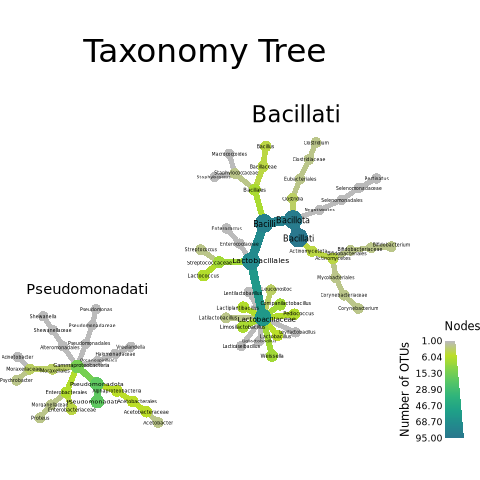

In [10]:
%%R
set.seed(1)

obj %>%
  filter_taxa(grepl("^[a-zA-Z]+$", taxon_names)) %>%
  filter_taxa(taxon_names %in% c("Bacillati", "Pseudomonadati", "Actinobacteria"),
              subtaxa = TRUE) %>%
  heat_tree(
    node_label = taxon_names,
    node_size  = n_obs,
    node_color = n_obs,   # <- use n_obs instead of root
    tree_label = taxon_names,
    initial_layout = "re",
    layout = "da",
    title = "Taxonomy Tree",
    node_color_axis_label = "Number of OTUs",
    node_size_axis_label = "Number of OTUs",
    output_file = "data/Visualizations/Kraken_tree_order.pdf"
  )
